2025-01-06 17:04:45.701783: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 17:04:45.702745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 17:04:45.705949: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 17:04:45.713096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736172285.725983   49989 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736172285.72

Mean Absolute Error (MAE): 0.12560779903697705
Mean Squared Error (MSE): 0.04936744868972063
Root Mean Squared Error (RMSE): 0.22218786800750537
                      Feature  Importance
1                   DayOfWeek    0.376846
4         CompetitionDistance    0.112639
0                       Store    0.086461
2                       Promo    0.077939
25             StateHoliday_a    0.053888
6    CompetitionOpenSinceYear    0.043842
5   CompetitionOpenSinceMonth    0.035348
19                StoreType_b    0.033145
26             StateHoliday_b    0.019777
12                        Day    0.018093


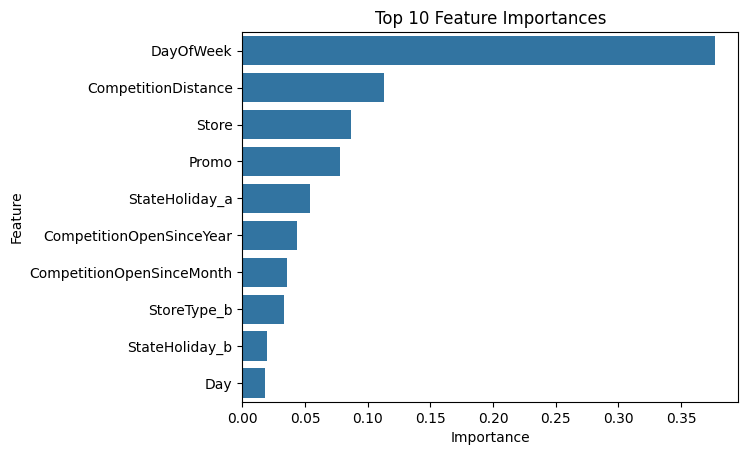

95% Confidence Interval: ±0.00096550114676884
Model saved as sales_prediction_model_2025-01-06-17-15-10.pkl


In [1]:

## Task 2: Prediction of Store Sales
### Step 1: Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin


### Step 2: Load the Dataset

# Load datasets
train_df = pd.read_csv('../data/rossmann_store_sales/train.csv')
store_df = pd.read_csv('../data/rossmann_store_sales/store.csv')
sample_submission_df = pd.read_csv('../data/rossmann_store_sales/sample_submission.csv')


### Step 3: Data Preprocessing

# Merge train and store datasets
merged_df = pd.merge(train_df, store_df, on='Store', how='left')

# Handle missing values
merged_df['CompetitionDistance'].fillna(merged_df['CompetitionDistance'].median(), inplace=True)
merged_df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
merged_df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
merged_df['Promo2SinceWeek'].fillna(0, inplace=True)
merged_df['Promo2SinceYear'].fillna(0, inplace=True)
merged_df['PromoInterval'].fillna('None', inplace=True)

# Convert date column to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Extract date-related features
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek
merged_df['IsWeekend'] = (merged_df['DayOfWeek'] >= 5).astype(int)
merged_df['IsMonthStart'] = merged_df['Date'].dt.is_month_start.astype(int)
merged_df['IsMonthEnd'] = merged_df['Date'].dt.is_month_end.astype(int)
merged_df['DaysToHoliday'] = (merged_df['Date'] - pd.to_datetime('2015-12-25')).dt.days.abs()
merged_df['DaysAfterHoliday'] = (pd.to_datetime('2015-12-25') - merged_df['Date']).dt.days.apply(lambda x: max(x, 0))

# Encode categorical features
merged_df = pd.get_dummies(merged_df, columns=['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'], drop_first=True)

# Drop unnecessary columns
merged_df.drop(['Customers', 'Open'], axis=1, inplace=True)

# Scale numeric features
scaler = StandardScaler()
scaled_columns = ['Sales', 'CompetitionDistance', 'DaysToHoliday', 'DaysAfterHoliday']
merged_df[scaled_columns] = scaler.fit_transform(merged_df[scaled_columns])


### Step 4: Build Model Using Sklearn Pipelines

# Define feature columns
feature_columns = [col for col in merged_df.columns if col not in ['Sales', 'Date']]
X = merged_df[feature_columns]
y = merged_df['Sales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)


### Step 5: Choose a Loss Function

# Evaluate model
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Justification for MAE: MAE provides an interpretable measure of average error in the same units as sales, making it easier to communicate with stakeholders.


### Step 6: Post Prediction Analysis

# Feature importance
importances = pipeline.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(10))

# Plot feature importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

# Confidence intervals (approximation using standard deviation of predictions)
pred_std = np.std(predictions - y_test)
confidence_interval = 1.96 * pred_std / np.sqrt(len(predictions))
print(f"95% Confidence Interval: ±{confidence_interval}")


### Step 7: Serialize Models

# Save the model
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"sales_prediction_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)
print(f"Model saved as {model_filename}")

